# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

**Note**

Il dataset contiene 0 valori mancanti per il campo *cfStrutturaProponente* ed 8445 valori mancanti per il campo *cfPrimoaggiudicatario*. I valori mancanti verranno eliminati durante la fase di generazione dei documenti sintetici. Nonostante l'eliminazione di elementi con valori nulli, essendo il dataset molto sporco ci sono diversi  valori inconsistenti. Ad esempio ci sono stringhe formate da soli spazi o di sola punteggiatura speciale, stringhe non associate a reali p.iva o codici fiscali (e.g. "extra UE USA", "USA", "USA00004215"). Per fare ricerche basate su sottostringhe esegui il comando: 

``` python
example_df = df[pd.notnull(df['cfPrimoaggiudicatario'])]
example_df[example_df['cfPrimoaggiudicatario'].str.contains("USA|usa")==True]
```

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term pesati per il loro tf-idf

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale cosi definita:

 
embedding(d<sub>i</sub>) = $ \frac{1}{\sum_{wj∈di} wj} * \sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.



## Soluzione 3: creazione di vettori basati su word embedding dei top term 

   Questa soluzione è molto simile alla precedente. Tuttavia in questa soluzione tutti i termini contribuiscono in ugual misura all'embedding del documento. 
   
   In questo modo è possibile rappresentare d<sub>i</sub> come il centroide dei suoi termini:

 embedding(d<sub>i</sub>) = $ \frac{1}{\{tj | tj∈di\}} * \sum_{tj ∈ di}$ embedding(t<sub>j</sub>)
 
 
## Future Works

1. Al fine di discriminare maggiormente i documenti, si possono analizzare non sono parole di lunghezza 1, ma anche n-grammi (in questo modo documenti come {"fattura luce", "fattura telefono"} risultano meno simili )

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [2]:
t0 = time()
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

total = time() - t0
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 16.432 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713154 entries, 0 to 1713153
Data columns (total 25 columns):
Unnamed: 0                           int64
cfStrutturaProponente                int64
cig                                  object
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           object
dataUltimazione                      object
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
cod_amm                              object
regione           

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [3]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

In [4]:
def aggregateByOggetto(col_groupBy, col_toAgg, df):
    """
    col_groupBy: è la colonna per la quale effettuare l'aggragazione
    col_toAgg: è la colonna contenente le informazioni non strutturate, i.e. campo "oggetto"
    df: input dataframe
    """
    df_noEmpty = df.dropna(subset=[col_toAgg], axis=0)
    new_series = df_noEmpty.groupby(col_groupBy)[col_toAgg].apply(lambda x: ' '.join(x)) 
    return pd.DataFrame(new_series)

In [5]:
final_df = pd.DataFrame(columns=['codiceFiscaleStruttura', 'oggetto', "tipoStruttura"])

In [6]:
for col, type_col in columns_to_aggregate:
    t0 = time()
    
    df_no_null = df[pd.notnull(df[col])]
    aggregate_df = aggregateByOggetto(col, "oggetto", df_no_null) 
    total = time() - t0

    aggregate_df['tipoStruttura'] = [type_col] * aggregate_df.shape[0]
    aggregate_df.reset_index(inplace = True)
    aggregate_df.rename(columns={col: 'codiceFiscaleStruttura'}, inplace = True)

    final_df = final_df.append(aggregate_df)
    
    print("Aggregation of attribute %s done in %0.3f sec" % (col, total))
    print(aggregate_df["oggetto"].head(3))


Aggregation of attribute cfPrimoaggiudicatario done in 13.856 sec
0    matconsumo laboratorio matconsumo laboratorio ...
1    servizio 22202 organizzazione incontri daffari...
2    SENSORI NGIMU with Housing and Battery  NGIMU ...
Name: oggetto, dtype: object
Aggregation of attribute cfStrutturaProponente done in 1.570 sec
0    MANUTENZIONE RECINZIONE E MESSA IN SICUREZZA C...
1    MANUTENZIONE AUTOMEZZO RIFIUTI RIPARAZIONE MEZ...
2    CORSO ANTINCENDIO NOMINA MEDICO E VISITE MEDIC...
Name: oggetto, dtype: object


In [7]:
pd.options.display.max_colwidth = 500
final_df.head()

,codiceFiscaleStruttura,oggetto,tipoStruttura
0,,matconsumo laboratorio matconsumo laboratorio bandiera con il logo della brigata Granatieri di Sardegna comprensiva di cornice in legno fasce identificative e cordoncini FP BAULE DA TRASPORTO cornice in legno bandiera con il logo dell Esercito Italiano Fornitura di prodotti disinfettanti per le strutture di ristorazione collettiva militare acquisto armadietti per la custodia di pistola fornitura resistenze per celle frigo prodotti per l igiene personale LUCCHETTI AD ARCO stoffa di colore bl...,AGG
1,,servizio 22202 organizzazione incontri daffari limitato ai servizi personalizzati agiuntivi albergo visto suto con autista transfer e CIP cosmoprof 47 dicembre 2017 ORDINE DACQUISTO Parandis per Prenotazione e riservazione albergo con visto per Sig Drusian di azienda Poliplast SERVIZIO 22202 Organizzazione incontri daffari Acquisto biglietti aerei TeheranIsfahanTeheran e prenotazione albergo a Isfahan per il vice responsabile ufficio ICE Teheran e TA incaricato in occasione fiera Isfahan ...,AGG
2,,SENSORI NGIMU with Housing and Battery NGIMU Body Strap Quotation 13 June 2017 PROF A MONTERIU DOTT A BELLI,AGG
3,1174219177,Servizio fotografico per PQ 2017,AGG
4,00000005792,SERVIZIO DI SVILUPPO ANNUALE DELLA CONTABILITA ARMONIZZATA ECONOMICO PATRIMONIALE DI CUI AL D LGS 1182011 TRIENNIO 2016 2018,AGG


In [8]:
t0 = time()
file_name = "data/oggetti_aggregati.pickle"
final_df.to_pickle(file_name)
total = time() - t0

print("Dataset stored in %0.3f sec" % total)

Dataset stored in 0.812 sec


In [9]:
## libera memoria
#una volta lanciato questo comando verranno perse tutte le variabili inizializzate in precedenza
#del [[df, final_df, aggregate_df]]
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Creazione Matrice TF-IDF

La matrice dei tf-idf verrà utilizzata per entrambe le soluzioni. Prima di generare la matrice, sono eseguite le seguenti attività di preprocessing:
- Tokenization;
- Eliminazione di stopword (e.g. di, a, dell, quell, etc. );
- Selezione di parole composte solo da lettere e di cardinalità maggiore di 2 (e.g. eliminazione di codici di fattura)

Alla matrice dei tf-idf generata è applicala la norma L2.


Inoltre si visualizzano di seguito le top 40 parole in termini di tf-idf.



In [59]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [60]:
from nltk.stem.snowball import ItalianStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from pylab import *

class StemmedCountVectorizer(TfidfVectorizer):
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        
def get_TFIDFmatrix_vect(data, do_stemming):
    """
    data: input textual collection
    do_stemming: boolean. If True execute stemming, otherwise analyze only tokenized words (words are composed at least 2 chars and do not contains numbers)
    
    returns a tuple <tf, matrix> where tf is the vectorizer and matrix is the normalized matrix of tfidf
    """
    t0 = time()
    
    min_df = 10
    
    if do_stemming:
        
        italian_stemmer = ItalianStemmer()
        tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', min_df = min_df, analyzer="word", stop_words=stopwords.words('italian'),  norm='l2')

    else:
        tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', stop_words=stopwords.words('italian'), min_df = min_df, norm='l2') #CountVectorizer supports counts of N-grams of words or consecutive characters.
    
    matrix = tf.fit_transform(data)  
    return matrix, tf

def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words[0:N]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)

    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'  
    fig.tight_layout() 
    plt.savefig(file_name, pad = 0) #png

    plt.clf
    return file_name

def boxplotdata(data_to_plot, title, x_names, filename):
    """
    data_to_plot: array containing variables to plot (e.g. [a,b,c] where a,b,c are arrays)
    title of the boxplot
    x_names: list containing axis names (e.g. ["boxplot1", "boxplot2"])
    filename: filename where saving the boxplot
    """
    #data_to_plot = [intersection]
    #k = len(D_embeddings[0])

    dim = range(1,len(x_names) +1)
    
    
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.xticks(dim, x_names)
    plt.title(title)


    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

    for line in bp['boxes']:
        x, y = line.get_xydata()[0] # bottom of left line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
        x, y = line.get_xydata()[3] # bottom of right line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

    plt.savefig(filename)
    plt.clf()
    plt.close()

In [61]:
from time import time
df_file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(df_file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

Dataset loaded in 0.243 sec


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307265 entries, 0 to 10965
Data columns (total 3 columns):
codiceFiscaleStruttura    307265 non-null object
oggetto                   307265 non-null object
tipoStruttura             307265 non-null object
dtypes: object(3)
memory usage: 9.4+ MB


In [63]:
t0 = time()

matrix, tf = get_TFIDFmatrix_vect(df.oggetto, False)
total = time() - t0
print("TFIDF matrix done in %0.3f sec" % total)
print("Shape TFIDF matrix", matrix.shape)

TFIDF matrix done in 18.045 sec
Shape TFIDF matrix (307265, 52004)


In [64]:
#import cPickle as pickle
import pickle
pickle.dump(tf, open("data/n6/tf.pickle", "wb"))

In [65]:
import scipy
scipy.sparse.save_npz('data/n6/sparse_matrix_tfidf.npz', matrix)

### Plot termini più discriminativi e distribuzione di termini per documento

Si può osservare come è poissibile identificare una decina di termini molto discriminativi (.e. fattura, fornitura, acquisto, pagamento, etc.). Inoltre, si nota che i documenti sintetici generati hanno, nella maggioranza dei casi, un numero di parole distinte compreso tra 6 e 21.

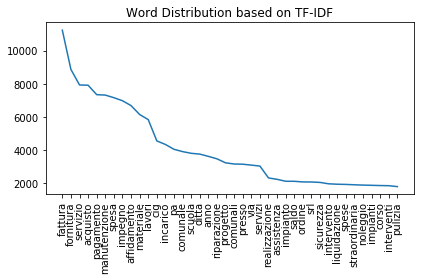

In [21]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

In [22]:
rows = (matrix != 0).sum(1)
values = np.squeeze(np.asarray(rows))

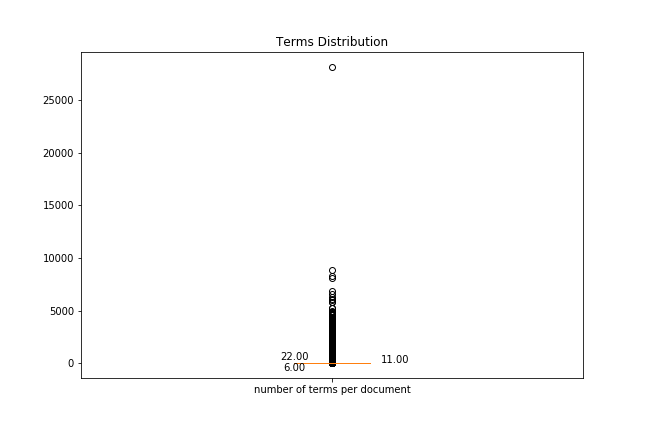

In [23]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(values)
plt.xticks([1], ["number of terms per document"])
plt.title("Terms Distribution")


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    text(x,y , '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    text(x, y*50, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

f_img = "imgs/n6/term_distribution.png"    
plt.savefig(f_img)
plt.clf()
plt.close()


i = Image(f_img)
display(i)

In [24]:
#genera lo stesso plot in plotly
#rows = (matrix != 0).sum(1)
#values = pd.value_counts(np.squeeze(np.asarray(rows)))

#trace = go.Box(y=np.squeeze(np.asarray(rows)))
#py.iplot([trace])    

In [25]:
#seleziona i 269 oggetti aventi una rappresentazione tfidf composta da soli zero
states = matrix.getnnz(1)== 0
row_indices = np.where(states)[0]
df.iloc[row_indices].head()

,codiceFiscaleStruttura,oggetto,tipoStruttura
230,000007199,665 ANJEZE PELINI,AGG
405,00013750203,PROORTGEMELLI103354,AGG
1591,00077910289,CONFAGRICOLTURA,AGG
2409,00103590220,CDATAOlive CDATAOlive CDATAOlive,AGG
5090,00167710359,Z601E221B6,AGG


## Implementazione Soluzione 1

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e a partire da questi è generata la matrice tf-idf.
Alla matrice sono poi applicate tecniche di dimensionality reduction (i.e. SVD) e standardization. 

### Dimensionality reduction

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import DBSCAN
t0 = time()
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
total = time() - t0
print("Preprocessing done in done in %0.3f sec" % total)

np.save("data/n6/matrix_tfidf", preprocessing)

Preprocessing done in done in 25.709 sec


In [27]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Implementazione Soluzione 2

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e per ogni elemento verrà generata una rappresentazione vettoriale basata su *FastText*. Come per l'implementazione della soluzione 1 verranno analizzati solo i top k termini piu frequenti (rispetto al tf-idf)

**NOTA BENE**

Per k = 1000, la generazione della matrice degli embedding (i.e. embedding_matrix) richiede qualche minuto; mentre per k = 44323 (ossia matrice termini documenti generata impostando min_df=10. Per maggiori dettagli, vedi  l'implementazione del metodo *get_TFIDFmatrix_vect* ) la generazione della matrice degli embedding richiede 3 giorni.

In [ ]:
from time import time
import pandas as pd
import numpy  as np
import math

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [ ]:
def calculate_embedding(tf, tfidf_matrix, n_rows, weigth_embedding = False) :
    """
    tf: Tf-idf vectorizer
    tfidf_matrix: matrix of tfidf
    n_row: number of rows to analize
    weigth_terms: Boolean. If true weigth the term embedding with its tfidf
    """
    
    embedded_matrix = np.zeros((n_rows,300), "float32")
    index_term_vocabulary = tf.get_feature_names()

    for i in range(0, n_rows):

        counter_d = 0

        #for term in the document:
        for index_t in tfidf_matrix[i].indices: 
            
            tfidf = tfidf_matrix[i,index_t]
            term = index_term_vocabulary[index_t]
            
            if term in jp_model.vocab:
                    
                    if(weigth_embedding):
                        counter_d += tfidf
                        embedded_matrix[i] += (jp_model.get_vector(term) * tfidf)
                    else:
                        counter_d += 1
                        embedded_matrix[i] += jp_model.get_vector(term)
                        
                    
        if counter_d > 0:

            embedded_matrix[i] /= counter_d
    
    return embedded_matrix

In [ ]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

In [ ]:
from gensim.models import KeyedVectors
t0 = time()
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

total = time() - t0
print("Fastext model loaded in %0.3f sec" % total)

#### Calcola intersezione tra i termini della matrice tf-idf e il vocabolario del modello fasttext

In [ ]:
not_present = []

t0 = time()
for term in tf.vocabulary_:
    if term not in jp_model.vocab:
            not_present.append(term)
total = time() - t0
print("Intersection done in %0.3f sec" % total)        

len_not_present = len(not_present) 
percentage = len_not_present / len(tf.vocabulary_) 
print("Percentage of absent terms: %0.2f (i.e. %d terms)" % (percentage, len_not_present)) 
print("Printing some term not present in Fastext model: ",not_present[:10])

In [ ]:
t0 = time()
weighted = False
embedded_matrix = calculate_embedding(tf, matrix, matrix.shape[0], weighted)

total = time() - t0 
print("Embedding done in %0.3f sec" % total)

In [ ]:
t = len(tf.vocabulary_)
f = "data/n6/matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, embedded_matrix)

In [ ]:
from sklearn.preprocessing import Normalizer
normalized_matrix = Normalizer(copy=False).fit_transform(embedded_matrix)
f = "data/n6/normalized_matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, normalized_matrix)

In [ ]:
%reset

## Costruzione del Grafo

A partire dalla matrice dei documenti sintetici calcolata nelle precedenti sezioni (tf-idf matrix o embedding matrix, entrambe normalizzate con L2) è possibile generate il  grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= *t*.

Impostiamo la threshold *t* = 0.6 

### Generazione Matrice similarità

In [ ]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [ ]:
#file_name = "data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npy"
file_name = "data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npy"
#file_name = "data/n6/matrix_tfidf.npy"

matrix = np.load(file_name).astype('float32')

In [ ]:
#check how many rows are all zero (it generates divisions by zero)
zero_rows = len(np.where(~matrix.any(axis=1))[0])
print("there are %d all zero rows" % zero_rows)

In [ ]:
#seleziona gli oggetti aventi una rappresentazione basata su embedding composta da soli zero
df_file_name = "data/oggetti_aggregati.pickle"
t0 = time()
df = pd.read_pickle(df_file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)
df.iloc[np.where(~matrix.any(axis=1))[0]].head()

In [ ]:
# NOTE: for cosine similarity you should normalize (in L2 norm) your input matrix
import faiss                   # make faiss available
index = faiss.IndexFlatIP(matrix.shape[1])   # build the index using inner product (ip)
print(index.is_trained)
index.add(matrix)                  # add vectors to the index
print(index.ntotal)

In [ ]:
from time import time

t0 = time()
k = 1000  # we want to see k nearest neighbors
#Matrix I is the results matrix
#Matrix D is the matrix of squared distances. It has the same shape as I and indicates for each result vector at the query’s squared Euclidean distance.
#
D, I = index.search(matrix, k) # sanity check

total = time() - t0
print("Cosine Similarity Matrix done in %0.3f sec" % total)
#print(I)
#print(D)


In [ ]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

In [ ]:
%reset

### Confronto Matrici 

La matrice generata dai tf-idf (i.e. Soluzione 1) sfrutta correlazioni dirette tra termini. Ossia due documenti sono simili se condividono gli stessi termini. Le matrici generate a partire dagli embedding dei termini (i.e. Soluzione 2, Soluzione 3) invece codificano correlazioni indirette tra termini. In quest'ultimo caso, due documenti sono simili se condividono termini semanticamente simili (e.g. raccolta, rifiuti, smaltimento).  

Per verificare se le rappresentazioni estratte per ogni documento codificano le stesse informazioni, si analizza l'intersezione dei k documenti più simili sfruttando le 3 matrici generate:
- Matrice tf-idf
- Matrice embedding
- Matrice embedding pesata con tf-idf

Per ogni coppia di matrici m1,m2, se queste codificano le stesse informazioni, allora per ogni documento d_i:

  
intersection(get_most_similar(m1, i, k), get_most_similar(m2, i, k))  ~= k,

dove *get_most_similar(mj, i, k)* restituisce i k documenti più simili al documento di indice i utilizzando la matrice mj. 



In [28]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [29]:
from pylab import *

def bar_plot(values, title, filename):

    # Turn interactive plotting off
    plt.ioff()

    p1 = plt.bar(values.index, values.values)

    plt.xlabel('# common documents')
    plt.title(title)

    #plt.show()
    plt.savefig(filename)
    plt.close()
    plt.clf
    i = Image(filename)
    display(i)

def get_intesection(set1, set2):
    intersection = []
    rows = len(set1)
    k = len(set1[0])
    for row in range(0, rows):
        i =  set(set1[row]).intersection(set(set2[row])) 
        #res = len(i) / k
        #intersection.append(float("{0:.2f}".format(res)))
        res = len(i)
        intersection.append(res)

    #return pd.value_counts(intersection) 
    return intersection

def box_plot(values, axis_names, title, filename):

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(values)
    dim = range(1, len(axis_names)+1)
    
    plt.xticks(dim, axis_names, rotation=90)
    plt.title(title)


    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

    for line in bp['boxes']:
        x, y = line.get_xydata()[0] # bottom of left line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
        x, y = line.get_xydata()[3] # bottom of right line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

    # Save the figure
    
    fig.savefig(filename, bbox_inches='tight')

    plt.close()
    plt.clf
    i = Image(filename)
    display(i)

In [131]:
I_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf= np.load("data/n6/matrix_tfidf.npysimilarity_I_100_k.npy")
D_tfidf = np.load("data/n6/matrix_tfidf.npysimilarity_D_100_k.npy")

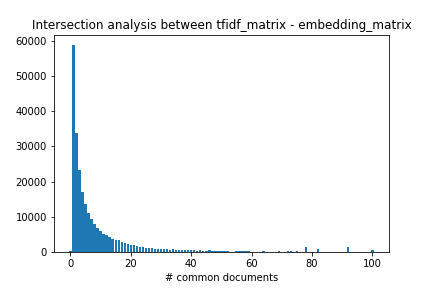

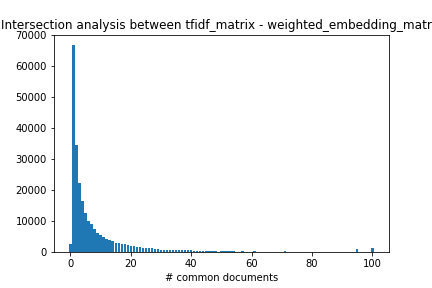

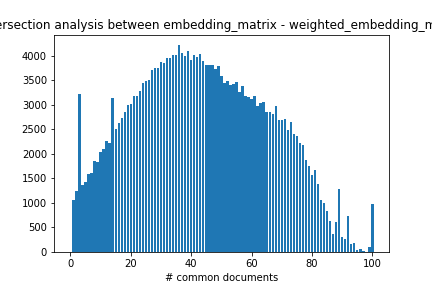

In [31]:
I_array = [I_tfidf, I_embeddings, I_embeddings_weighted]
k = len(I_embeddings[0])
labels = ["tfidf_matrix", "embedding_matrix", "weighted_embedding_matrix"]
intersection_array = []
str_labels = []

for i in range(len(I_array)):
    for j in range(i+1, len(I_array)):

        intersection = get_intesection(I_array[i], I_array[j])
        intersection_array.append(intersection[:100000])
        title = "Intersection analysis between " + labels[i] + " - " + labels[j]
        f_img = "imgs/n6/intersection_"+ labels[i] + "." + labels[j] + "_k"+ str(k)+ ".png"
        str_labels.append(labels[i] + " vs " + labels[j])
        bar_plot(pd.value_counts(intersection), title,f_img)


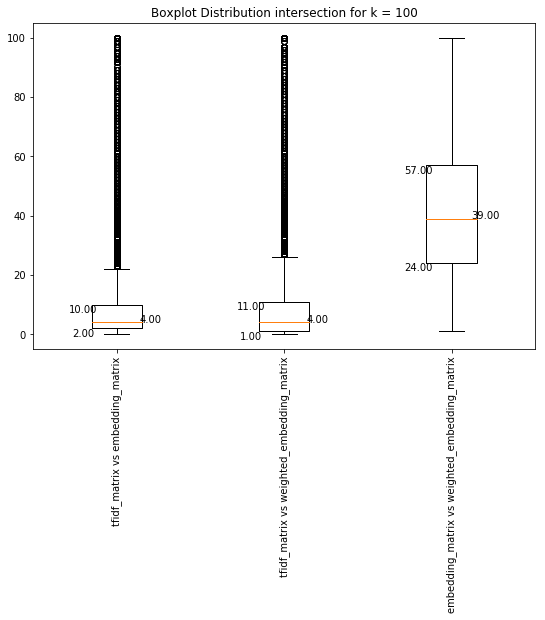

In [32]:
title = "Boxplot Distribution intersection for k = " + str(k)
filename = "imgs/n6/boxplot_comparisons_k"+ str(k)+ ".png"
       
box_plot(intersection_array, str_labels, title, filename)

Di seguito si mostrano anche le distribuzioni dei valori di similarità 

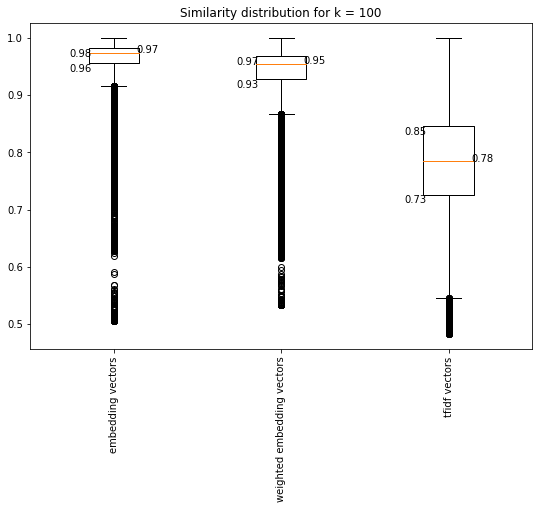

In [33]:
data_to_plot = [D_embeddings.ravel() [:100000], D_embeddings_weighted.ravel()[:100000],D_tfidf.ravel()[:100000]]
axis_labels = ['embedding vectors', 'weighted embedding vectors','tfidf vectors']
title = "Similarity distribution for k = "+ str(k)
filename = "imgs/n6/similarities_comparisons_k"+ str(k)+ ".png"
box_plot(data_to_plot, axis_labels, title, filename)

### Visualizzazione dettaglio documenti strutture (i.e. Pa e Aggiudicatari) simili

Perchè questa parte funzioni occorre rilanciare la generazione del tf-idf

In [132]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

In [133]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    #top_feats = [(features[i], row[i]) for i in topn_ids if row[i] > 0]
    top_feats = [features[i] + ":" + "{0:.2f}".format(row[i]) for i in topn_ids if row[i] > 0]
    #df = pd.DataFrame(top_feats)
    #df.columns = ['feature', 'tfidf']
    return top_feats

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def get_best_terms_frequencies(Xtr, features, rows_id, top_n=25):
    return [' '.join(top_feats_in_doc(Xtr,  features, row ,top_n)) for row in rows_id]
    

In [134]:
#scegli struttura da analizzare (scelta basata su indice di riga della matrice)
iloc_document_to_compare = 1000 #i.e. si sta analizzando la struttura 1000

#scegli la matrici da confrontare
I_matrix1 = I_embeddings
D_matrix1 = D_embeddings

I_matrix2 = I_tfidf
D_matrix2 = D_tfidf


In [135]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df_aggregati = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df_aggregati.info()

Dataset loaded in 0.174 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307265 entries, 0 to 10965
Data columns (total 3 columns):
codiceFiscaleStruttura    307265 non-null object
oggetto                   307265 non-null object
tipoStruttura             307265 non-null object
dtypes: object(3)
memory usage: 9.4+ MB


In [136]:
import pickle
tf = pickle.load(open("data/n6/tf.pickle", "rb"))
import scipy
m = scipy.sparse.load_npz('data/n6/sparse_matrix_tfidf.npz')

In [138]:
commons_docs =  set(I_matrix1[iloc_document_to_compare]).intersection(set(I_matrix2[iloc_document_to_compare]))
print("Documenti in comune: ", commons_docs)

Documenti in comune:  {3808, 545, 5185, 2084, 1350, 1000, 2763, 300, 1393, 5335, 536, 4185, 1722, 1726}


In [139]:
pd.options.display.max_colwidth = 500
df_aggregati.iloc[[iloc_document_to_compare]]

,codiceFiscaleStruttura,oggetto,tipoStruttura
1000,00053830451,Pagamento Fattura n52PA del 28102017 MATERIALE PER LABORATORIO SCIENZECHIMICA Affidamento diretto per fornitura materiale vario per edilizia ed agricoltura da impiegare nei lavori forestali alla Ditta Flli De Negri di Pontremoli FORNITURA MATER PER CAMINO DITTA DE NEGRI PN FORNITURA GRIGLIE DI SCARICO ACQUE PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER VERNICIATURA PER PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER EDILE DITTA DE NEGRI PN FORNITURA MATERIALE EDILE DITTA DE NEGRI PN FORNIT...,AGG


In [142]:
df_most_similar = df_aggregati.iloc[list(commons_docs)]
df_most_similar["top_terms"] = get_best_terms_frequencies(m, tf.get_feature_names(), commons_docs, 10)
df_most_similar

,codiceFiscaleStruttura,oggetto,tipoStruttura,top_terms
3808,00137020871,SALDO FATTURA N2103 DEL 15032017 VISITA GUIDATA PALAZZO DELLA CULTURA CLASSE 2Q GIORNO 14032017 affitto sala per convegno Affitto spazio piscine Nesima da introitare al Cap 318 Bilancio 2016 mese di Dicembre 2016 e Gennaio 2017 Affitto spazio piscine Nesina da introitare al Cap 318 Bilancio 2017 mese di Febbraio 2017 Affitto spazio piscine Nesima da introitare al Cap 318 Bilancio 2017 mesi di Marzo e Aprile 2017 RINNOVO SERVIZIO OSANET 2018 Ordine n54 UTILIZZO SALA COMUNALE PER CONVEGNO Abb...,AGG,amt:0.50 mese:0.35 ct:0.26 affitto:0.25 piscine:0.25 abbonamento:0.23 cap:0.20 nesima:0.20 spazio:0.18 bilancio:0.17
545,00027700442,INCARICO TECNICO PER REDAZIONE APE,AGG,ape:0.68 redazione:0.47 tecnico:0.45 incarico:0.34
5185,00169780699,CDATALAVORI ELETTRICI PALAZZINA N PO SS Annunziata sistemazione impianto di illuminazione esterna dellarea adibita a Centro Espositivo DD 98I del 17052017 PROIETTI CAMILLO REALIZZAZIONE IMPIANTO DI TRASMISSIONE VIDEO IN ALTA DEFINIZIONE PRESSO LA SALA ROSSA DELLA SEDE CAMERALE DI VIA FLLI POMILIO DD 95I DEL 15052017 PROIETTI CAMILLO,AGG,proietti:0.45 camillo:0.41 dd:0.25 pomilio:0.25 adibita:0.19 annunziata:0.19 espositivo:0.18 impianto:0.18 camerale:0.17 rossa:0.17
2084,00095270930,CDATA10TDM00 CRON 2264 DEL 13102017 OPERA N 9817 LAVORI DI RIQUALIFICAZIONE EX CONVENTO DI SAN FRANCESCO LAVORI EDILI PRELIMINARI E SUCCESSIVI AI LAVORI IMPIANTISTICI,AGG,lavori:0.34 impiantistici:0.34 tdm:0.33 successivi:0.32 preliminari:0.31 cron:0.31 convento:0.30 cdata:0.25 francesco:0.23 edili:0.21
1350,00067980086,Materiale risanamento aule Materiale risanamento 2 aule ITIS Teli di protezione per pitturazione aule Materiale consumo ferramenta,AGG,aule:0.62 risanamento:0.43 materiale:0.33 itis:0.28 pitturazione:0.28 teli:0.27 ferramenta:0.19 protezione:0.17 consumo:0.16
1000,00053830451,Pagamento Fattura n52PA del 28102017 MATERIALE PER LABORATORIO SCIENZECHIMICA Affidamento diretto per fornitura materiale vario per edilizia ed agricoltura da impiegare nei lavori forestali alla Ditta Flli De Negri di Pontremoli FORNITURA MATER PER CAMINO DITTA DE NEGRI PN FORNITURA GRIGLIE DI SCARICO ACQUE PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER VERNICIATURA PER PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER EDILE DITTA DE NEGRI PN FORNITURA MATERIALE EDILE DITTA DE NEGRI PN FORNIT...,AGG,negri:0.50 pn:0.40 de:0.29 mater:0.29 edile:0.21 ditta:0.20 fivizzano:0.18 fornitura:0.17 pontremoli:0.17 materiale:0.17
2763,00111630513,CDATAImponibile fattura 1 del 6317stampa pieghevoli per orientamento as 201718,AGG,cdataimponibile:0.63 pieghevoli:0.46 orientamento:0.41 stampa:0.31 as:0.30 fattura:0.21
300,00004800017,REALIZZAZIONE E FORNITURA DI 10 BLOCCHI RICEVUTE FORMATO A5 A 100 FOGLI Acquisto materiale pubblicitario per lorientamento,AGG,lorientamento:0.49 ricevute:0.43 blocchi:0.36 fogli:0.34 formato:0.33 pubblicitario:0.33 realizzazione:0.20 materiale:0.17 acquisto:0.15 fornitura:0.14
1393,00069880391,Fornitura di tubo raccordi e rubinetti per manutenzione acquedotti Fornitura di materiale idraulico manutenzione acquedotti acquisto fertirrigatore FORNITURA TUTORI FRUTTETO DLGS 502016 ART 36 COMMA 2 LETT B DELIBERA N 922017 OBIETTIVO 2 ATTIVIT 2 DETERMINA A CONTRARRE N 41822017 DETERMINE DI AGGIUDICAZIONE N 62492017 E 71502017 ACQUISIZIONE DEL SERVIZIO DI PROVE SPERIMENTALI SUDDIVISO IN SETTE LOT,AGG,acquedotti:0.42 frutteto:0.26 lot:0.26 tutori:0.25 suddiviso:0.24 sperimentali:0.22 sette:0.21 rubinetti:0.21 obiettivo:0.21 fornitura:0.20
5335,00173270596,FIORI PER SERRA AZIENDA AGRARIA Pagamento Fattura n42 del 08032017 PIANTE PER SERRA AZIENDA AGRARIA Pagamento Fattura n8 del 31012017 PIANTE DA SERRA AZIENDA AGRARIA Pagamento Fattura n52 del 30032017 PIANTE DA SERRA AZIENDA AGRARIA Pagamento Fattura n37 del 03032017 PIANTE PER SERRA Fatt 35 del 0303 acquisto piantine orto e talee gerani vari tipi,AGG,serra:0.57 agraria:0.48 azienda:0.39 piante:0.36 pagament

In [123]:
df_most_similar

,oggetto,tipoStruttura,pippo
codiceFiscaleStruttura,,,
00137020871,SALDO FATTURA N2103 DEL 15032017 VISITA GUIDATA PALAZZO DELLA CULTURA CLASSE 2Q GIORNO 14032017 affitto sala per convegno Affitto spazio piscine Nesima da introitare al Cap 318 Bilancio 2016 mese di Dicembre 2016 e Gennaio 2017 Affitto spazio piscine Nesina da introitare al Cap 318 Bilancio 2017 mese di Febbraio 2017 Affitto spazio piscine Nesima da introitare al Cap 318 Bilancio 2017 mesi di Marzo e Aprile 2017 RINNOVO SERVIZIO OSANET 2018 Ordine n54 UTILIZZO SALA COMUNALE PER CONVEGNO Abb...,AGG,amt:0.50 mese:0.35 ct:0.26 affitto:0.25 piscine:0.25 abbonamento:0.23 cap:0.20 nesima:0.20 spazio:0.18 bilancio:0.17
00027700442,INCARICO TECNICO PER REDAZIONE APE,AGG,ape:0.68 redazione:0.47 tecnico:0.45 incarico:0.34
00169780699,CDATALAVORI ELETTRICI PALAZZINA N PO SS Annunziata sistemazione impianto di illuminazione esterna dellarea adibita a Centro Espositivo DD 98I del 17052017 PROIETTI CAMILLO REALIZZAZIONE IMPIANTO DI TRASMISSIONE VIDEO IN ALTA DEFINIZIONE PRESSO LA SALA ROSSA DELLA SEDE CAMERALE DI VIA FLLI POMILIO DD 95I DEL 15052017 PROIETTI CAMILLO,AGG,proietti:0.45 camillo:0.41 dd:0.25 pomilio:0.25 adibita:0.19 annunziata:0.19 espositivo:0.18 impianto:0.18 camerale:0.17 rossa:0.17
00095270930,CDATA10TDM00 CRON 2264 DEL 13102017 OPERA N 9817 LAVORI DI RIQUALIFICAZIONE EX CONVENTO DI SAN FRANCESCO LAVORI EDILI PRELIMINARI E SUCCESSIVI AI LAVORI IMPIANTISTICI,AGG,lavori:0.34 impiantistici:0.34 tdm:0.33 successivi:0.32 preliminari:0.31 cron:0.31 convento:0.30 cdata:0.25 francesco:0.23 edili:0.21
00067980086,Materiale risanamento aule Materiale risanamento 2 aule ITIS Teli di protezione per pitturazione aule Materiale consumo ferramenta,AGG,aule:0.62 risanamento:0.43 materiale:0.33 itis:0.28 pitturazione:0.28 teli:0.27 ferramenta:0.19 protezione:0.17 consumo:0.16
00053830451,Pagamento Fattura n52PA del 28102017 MATERIALE PER LABORATORIO SCIENZECHIMICA Affidamento diretto per fornitura materiale vario per edilizia ed agricoltura da impiegare nei lavori forestali alla Ditta Flli De Negri di Pontremoli FORNITURA MATER PER CAMINO DITTA DE NEGRI PN FORNITURA GRIGLIE DI SCARICO ACQUE PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER VERNICIATURA PER PO FIVIZZANO DITTA DE NEGRI PN FORNITURA MATER EDILE DITTA DE NEGRI PN FORNITURA MATERIALE EDILE DITTA DE NEGRI PN FORNIT...,AGG,negri:0.50 pn:0.40 de:0.29 mater:0.29 edile:0.21 ditta:0.20 fivizzano:0.18 fornitura:0.17 pontremoli:0.17 materiale:0.17
00111630513,CDATAImponibile fattura 1 del 6317stampa pieghevoli per orientamento as 201718,AGG,cdataimponibile:0.63 pieghevoli:0.46 orientamento:0.41 stampa:0.31 as:0.30 fattura:0.21
00004800017,REALIZZAZIONE E FORNITURA DI 10 BLOCCHI RICEVUTE FORMATO A5 A 100 FOGLI Acquisto materiale pubblicitario per lorientamento,AGG,lorientamento:0.49 ricevute:0.43 blocchi:0.36 fogli:0.34 formato:0.33 pubblicitario:0.33 realizzazione:0.20 materiale:0.17 acquisto:0.15 fornitura:0.14
00069880391,Fornitura di tubo raccordi e rubinetti per manutenzione acquedotti Fornitura di materiale idraulico manutenzione acquedotti acquisto fertirrigatore FORNITURA TUTORI FRUTTETO DLGS 502016 ART 36 COMMA 2 LETT B DELIBERA N 922017 OBIETTIVO 2 ATTIVIT 2 DETERMINA A CONTRARRE N 41822017 DETERMINE DI AGGIUDICAZIONE N 62492017 E 71502017 ACQUISIZIONE DEL SERVIZIO DI PROVE SPERIMENTALI SUDDIVISO IN SETTE LOT,AGG,acquedotti:0.42 frutteto:0.26 lot:0.26 tutori:0.25 suddiviso:0.24 sperimentali:0.22 sette:0.21 rubinetti:0.21 obiettivo:0.21 fornitura:0.20


In [113]:
['#'.join(top_feats_in_doc(m,  tf.get_feature_names(), el, 10)) for el in i]

['amt:0.50#mese:0.35#ct:0.26#affitto:0.25#piscine:0.25#abbonamento:0.23#cap:0.20#nesima:0.20#spazio:0.18#bilancio:0.17',
 'ape:0.68#redazione:0.47#tecnico:0.45#incarico:0.34',
 'proietti:0.45#camillo:0.41#dd:0.25#pomilio:0.25#adibita:0.19#annunziata:0.19#espositivo:0.18#impianto:0.18#camerale:0.17#rossa:0.17',
 'lavori:0.34#impiantistici:0.34#tdm:0.33#successivi:0.32#preliminari:0.31#cron:0.31#convento:0.30#cdata:0.25#francesco:0.23#edili:0.21',
 'aule:0.62#risanamento:0.43#materiale:0.33#itis:0.28#pitturazione:0.28#teli:0.27#ferramenta:0.19#protezione:0.17#consumo:0.16',
 'negri:0.50#pn:0.40#de:0.29#mater:0.29#edile:0.21#ditta:0.20#fivizzano:0.18#fornitura:0.17#pontremoli:0.17#materiale:0.17',
 'cdataimponibile:0.63#pieghevoli:0.46#orientamento:0.41#stampa:0.31#as:0.30#fattura:0.21',
 'lorientamento:0.49#ricevute:0.43#blocchi:0.36#fogli:0.34#formato:0.33#pubblicitario:0.33#realizzazione:0.20#materiale:0.17#acquisto:0.15#fornitura:0.14',
 'acquedotti:0.42#frutteto:0.26#lot:0.26#tutori:

In [108]:
'#'.join(top_feats_in_doc(m,  tf.get_feature_names(), 300, 10))

'lorientamento:0.49#ricevute:0.43#blocchi:0.36#fogli:0.34#formato:0.33#pubblicitario:0.33#realizzazione:0.20#materiale:0.17#acquisto:0.15#fornitura:0.14'

In [110]:
top_feats_in_doc(m,  tf.get_feature_names(), 5335, 10)

['serra:0.57',
 'agraria:0.48',
 'azienda:0.39',
 'piante:0.36',
 'pagamento:0.21',
 'fattura:0.20',
 'gerani:0.15',
 'tipi:0.14',
 'piantine:0.12',
 'orto:0.11']

In [ ]:
from utils import enrich_data_with_indicepa as enrich 
df_enriched = enrich.enrich_data(df_most_similar.index.astype(str))
print(df_enriched.shape)
df_enriched.set_index("cf", inplace = True)

In [ ]:
df_enriched

In [ ]:
cf_set_amm

In [ ]:

import pandas as pd
import numpy
import csv

file_amministrazioni = "data/indicePA/amministrazioni.txt"
file_aoo = "data/indicePA/aoo.txt"
file_ou = "data/indicePA/ou.txt"
file_PEC_CECPAC = "data/indicePA/pec.txt"
file_serv_fatt = "data/indicePA/serv_fatt.txt"

df_amm = pd.read_csv(file_amministrazioni, sep="\t", dtype=object)
df_amm = df_amm[[ 'cod_amm','Cf','Comune', 'Provincia', 'Regione', 'Indirizzo', 'tipologia_istat', 'tipologia_amm', 'acronimo']]
cf_set_amm = set(df_amm.Cf.values)

df_serv_fatt = pd.read_csv(file_serv_fatt, sep="\t", dtype=object)
df_serv_fatt = df_serv_fatt.rename(columns={'cf': 'Cf'})

cf_set_serv_fatt = set(df_serv_fatt.Cf.values)
cf_set_amm = set(df_amm.Cf.values)

columns = ["cf", "cod_amm", "regione", "provincia", "comune", "indirizzo", "tipologia_istat", "tipologia_amm"]

final_df = pd.DataFrame(columns=columns)

count = 0

for cf in data:
    if(cf in cf_set_amm):
        print("pippo")    
        try:
            cod_amm = df_amm.loc[df_amm['Cf'] == cf].iloc[0]['cod_amm']
            take0 = df_amm.loc[df_amm['cod_amm'] == cod_amm].iloc[0]
            regione = take0['Regione'].replace("\t", "")
            provincia = str(take0['Provincia']).replace("\t", "")
            comune = take0['Comune'].replace("\t", "")
            indirizzo = take0['Indirizzo'].replace("\t", "")
            tipologia_istat = take0['tipologia_istat'].replace("\t", "")
            tipologia_amm = take0['tipologia_amm'].replace("\t", "")

            res = [cf, cod_amm, regione, provincia, comune, indirizzo, tipologia_istat, tipologia_amm]
            final_df.loc[len(final_df)] = res
        except: # catch *all* exceptions
            print("CF in df_amm",cf)
    elif(cf in cf_set_serv_fatt):
        print("pluto")    
        try:
            print("ciao")
            cod_amm = df_serv_fatt.loc[df_serv_fatt['Cf'] == cf].iloc[0]['cod_amm']
            take0 = df_amm.loc[df_amm['cod_amm'] == cod_amm].iloc[0]
            regione = take0['Regione'].replace("\t", "")
            provincia = str(take0['Provincia']).replace("\t", "")
            comune = take0['Comune'].replace("\t", "")
            indirizzo = take0['Indirizzo'].replace("\t", "")
            tipologia_istat = take0['tipologia_istat'].replace("\t", "")
            tipologia_amm = take0["tipologia_amm"].replace("\t", "")
            res = [cf, cod_amm, regione, provincia, comune, indirizzo, tipologia_istat, tipologia_amm]
            final_df.loc[len(final_df)] = res
        except: # catch *all* exceptions
            print("CF in df_serv_fatt",cf)
    else:
        count = count + 1

print("Totale cf non presenti in IndicePA: ", count)

In [ ]:
df_serv_fatt.loc[df_serv_fatt['Cf']== 192730299]

In [ ]:
df.loc[df['cfStrutturaProponente'].astype(str) == '192730299']

### Confronto distribuzioni similarità

### Dettaglio documenti strutture (i.e. PA, Aggiudicatari) simili

In [ ]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df.info()

In [ ]:
from utils import enrich_data_with_indicepa as enrich 
df_enriched = enrich.enrich_data(df.codiceFiscaleStruttura.astype(str))
print(df_enriched.shape)
df_enriched.set_index("cf", inplace = True)

In [ ]:
i =  set(I_embeddings[row]).intersection(set(I_tfidf[row]))
print("Documenti in comune: ", i)

In [ ]:
df.iloc[[iloc_document_to_compare]]

In [ ]:
pd.options.display.max_colwidth = 500
df_I_embedding = df.iloc[I_embeddings[iloc_document_to_compare]]
df_I_embedding["codiceFiscaleStruttura"] = df_I_embedding["codiceFiscaleStruttura"].astype(str)
df_I_embedding.set_index("codiceFiscaleStruttura", inplace= True)

#df_I_embedding.head()
#aggiunge info da indice Pa se il codice fiscale è inluso
df_I_embedding.join(df_enriched)

In [ ]:
pd.options.display.max_colwidth = 500

df_I_tfidf = df.iloc[I_tfidf[iloc_document_to_compare]]
df_I_tfidf["codiceFiscaleStruttura"] = df_I_tfidf["codiceFiscaleStruttura"].astype(str)
df_I_tfidf.set_index("codiceFiscaleStruttura", inplace= True)

#df_I_embedding.head()
#aggiunge info da indice Pa se il codice fiscale è inluso
df_I_tfidf.join(df_enriched)


In [ ]:
D_embeddings[:10]

In [ ]:
[D_embeddings[iloc_document_to_compare]]

In [ ]:
[D_tfidf[iloc_document_to_compare]]

In [ ]:
#visualizza i termini con i valori piu alti di tf-idf
#top_feats_in_doc(matrix,  tf.get_feature_names(), 1000, 5)

In [ ]:
type(D_embeddings[0])

In [ ]:
df[df["tipoStruttura"] == "PA"].shape

In [ ]:
cosine_iterator = cosine_similarity(matrix)

In [ ]:
from scipy.sparse import lil_matrix

t0 = time()

cosine_matrix = lil_matrix((matrix.shape[0], matrix.shape[0]))
#cosine_matrix = lil_matrix((1000, 1000))
counter = 0
for x in cosine_iterator:
    if(x[2]>= 0.6):
        cosine_matrix[x[0],x[1]] = x[2]
        counter += 1
        
total = time() - t0
print("Cosine Matrix done in %0.3f sec" % total)
print("There are %d pairs with a cosine similarity greater than 0.6" % counter)

np.save("data/n6/cosine_matrix", cosine_matrix)

In [ ]:
counter

In [ ]:
#from multiprocessing import Pool
#from scipy import spatial
#from time import time

#n = matrix.shape[0]
#lst = ((i, j) for i in range(0, n) for j in range(i+1,n))

#def cosine(p):
#    i = p[0]
#    j = p[1]
    
#    if spatial.distance.cosine(matrix[i], matrix[j]) > 0.6:
#        return i,j, 1 - spatial.distance.cosine(matrix[i], matrix[j])

##if __name__ == '__main__':

#t0 = time()
#p = Pool(6)
#a = p.imap(cosine, lst)
#total = time() - t0
#print(total)
#a = filter(None, a)

In [ ]:
counter = 0
for el in a:
    counter += 1

In [ ]:
print(counter)

## References

[1] https://buhrmann.github.io/tfidf-analysis.html